# Quantifying semisc similarity
## Chapter X: 032-Patch-retrieval-PCA

### Author: Anders Kampenes

### 032-Patch-retrieval-PCA

In [ ]:
### Loading and preparing dataset

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image, plot_similar_image,  plot_random_directions, plot_subset_of_directions  
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data
from scripts.data_utils.grid_utils import pad_data_to_fit_patch, blockshaped, unblockshaped, plot_embeddings, create_patched_data, plot_patched_directions

chapterName = "032-Patch-retrieval-PCA"
prevChapterName = "02-data_sequence_analysis_patch"
input_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + prevChapterName
output_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + chapterName
data_cube = np.load("/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/data/processed/f3_entire_int8.npy")

print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])
print(shape)


img shape (651, 951, 462)
651 951 462
{'inline': [951, 462], 'xline': [651, 462], 'tline': [651, 951]}


68


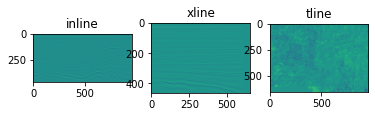

In [2]:


# plt different slices 
plot_random_directions(data, 100)


   

In [9]:
# we have now padded all directions and can extract patched of patch_size 
#
patch_size = 64

padded_data = pad_data_to_fit_patch(data, patch_size, directions, num_samples, input_folder)
for dir in directions:
    print("padded_data", padded_data[dir].shape)
    
patched_data, patched_labels, patched_labels_per_image, patched_labels_per_grid_cell, patched_labels_per_grid_cell, patched_grid_sizes, patched_num_smaples =  create_patched_data(padded_data, patch_size, directions)





padding_needed {'inline': 53, 'xline': 9, 'tline': 50}
Found inline
Found xline
Found tline
padded_data (704, 960, 512)
padded_data (960, 704, 512)
padded_data (512, 960, 704)
dir shape (704, 960, 512)
nm 15 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [703. 703. 703. 703. 703. 703. 703. 703. 703. 703.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [110. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
dir shape (960, 704, 512)
nm 11 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [959. 959. 959. 959. 959. 959. 959. 959. 959. 959.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [78. 79. 80. 81. 82. 83. 8

random_slice 53640
patched_slice (120, 64, 64)


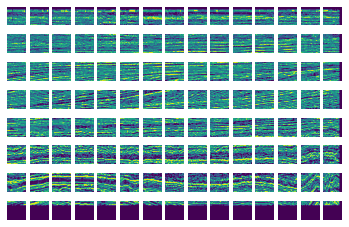

random_slice 43208
patched_slice (88, 64, 64)


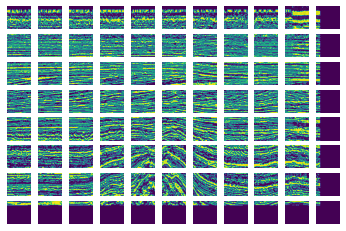

random_slice 8910
patched_slice (165, 64, 64)


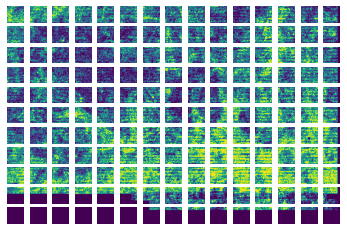

In [10]:
# plot random patches to verify

plot_patched_directions(padded_data, patched_data, patched_grid_sizes, patch_size, directions, output=False)    
        
    

In [ ]:
### Dimension reduction and visualization with PCA

In [11]:
from sklearn.cluster import KMeans
# flatten directions 
patched_data["inline"] = patched_data["inline"].reshape(patched_grid_sizes["inline"][0], -1)
patched_data["xline"] = patched_data["xline"].reshape(patched_grid_sizes["xline"][0], -1)
patched_data["tline"] = patched_data["tline"].reshape(patched_grid_sizes["tline"][0], -1)
print("flattten dirs", patched_data["inline"].shape, patched_data["xline"].shape, patched_data["tline"].shape )



flattten dirs (84480, 4096) (84480, 4096) (84480, 4096)


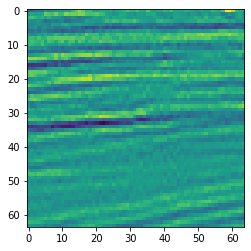

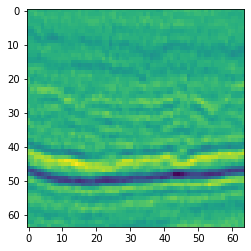

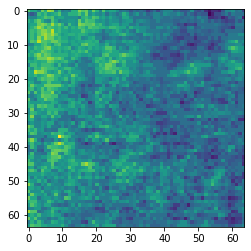

In [5]:

# verify one a single path on ech
for dir in directions:
    random = np.random.choice(patched_data[dir].shape[0], 1)[0]
    plt.imshow(patched_data[dir][random].reshape(patch_size,patch_size))
    plt.show()

In [12]:
# get the data from last chapter

pca = {}

for dir in directions:
    # TODO REMOVE just for veriication 
    patched_data[dir] = patched_data[dir][0:10000]
    patched_labels[dir] = patched_labels[dir][0:10000]
    patched_labels_per_image[dir] = patched_labels_per_image[dir][0:10000]
    patched_labels_per_grid_cell[dir] = patched_labels_per_grid_cell[dir][0:10000]

    print(patched_labels[dir].shape)
    
    
   
    filename = input_folder + "/pca_" + dir + ".npy"
    if not os.path.exists(filename):
        print("did not find data.. creating new...")
        print("dir", dir, patched_data[dir].shape, len(patched_labels[dir]), patched_num_smaples[dir])
        pca_digits=PCA(2)
        pca[dir] = pca_digits.fit_transform(patched_data[dir]) 
        print(np.sum(pca_digits.explained_variance_ratio_))
        # store the data 
        np.save(filename, pca[dir])
    else:
        print("found data. loading it to memory")
        pca[dir] = np.load(filename)
    
    

(10000,)
found data. loading it to memory
(10000,)
found data. loading it to memory
(10000,)
found data. loading it to memory


num_labelsss 9999 9999.0
num_labelsss 9999 9999.0
num_labelsss 9999 9999.0


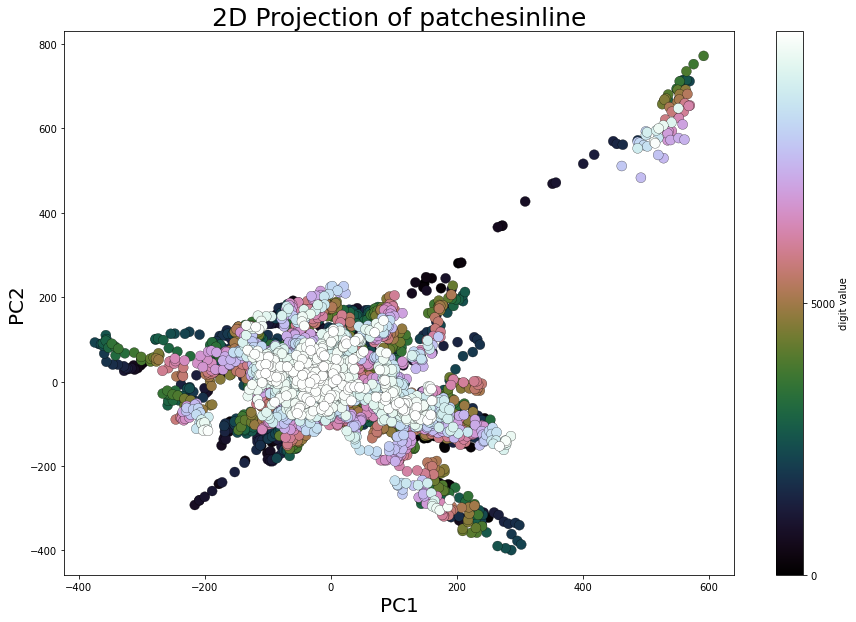

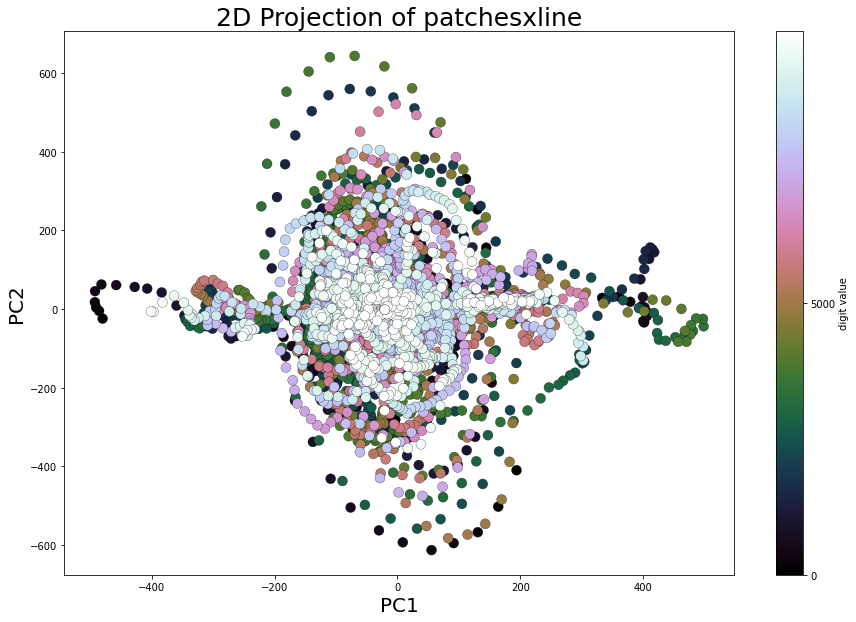

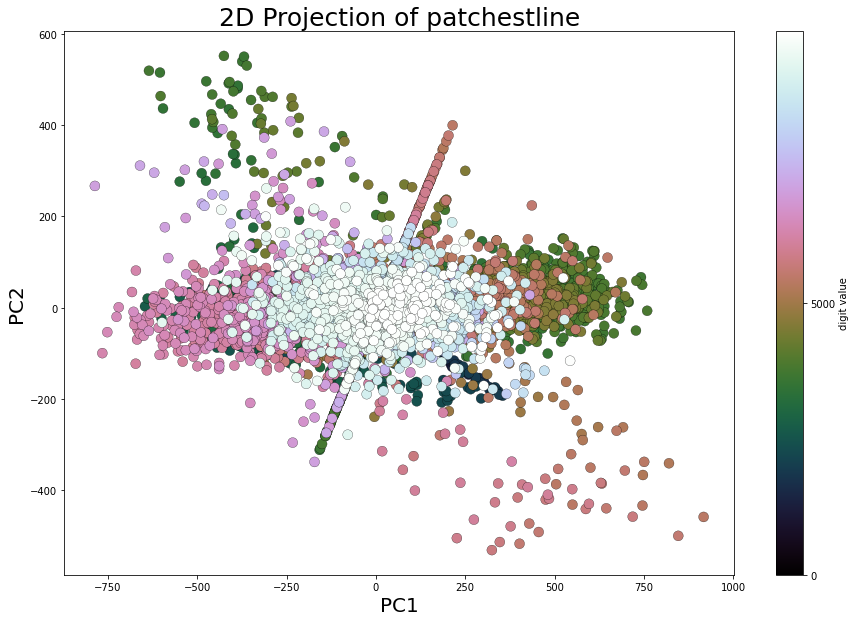

In [26]:

### plot pca of each direciton
for dir in directions:
    labelss =patched_labels[dir]
    num_labelss = int(np.max(labelss))
    print("num_labelsss", num_labelss, labelss[-1])
    scatter(pca[dir], labelss, num_labelss, dir, show_labels=False) 

pca[dir] (10000, 2)
pca[dir] (10000, 2)
pca[dir] (10000, 2)


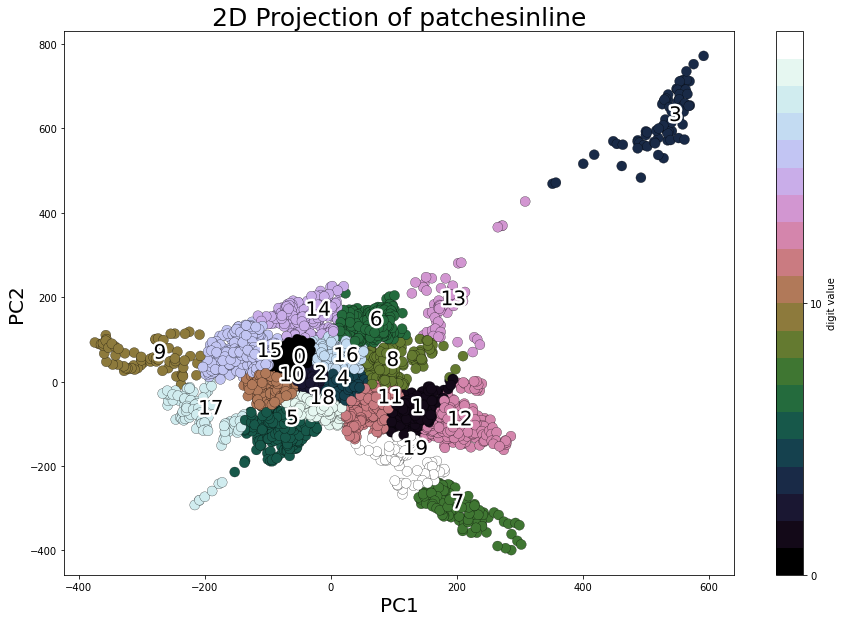

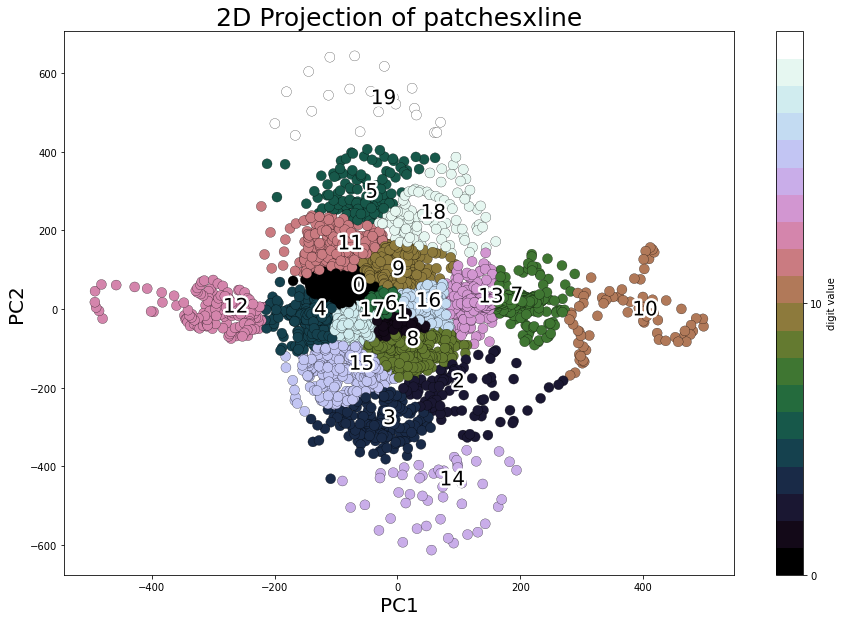

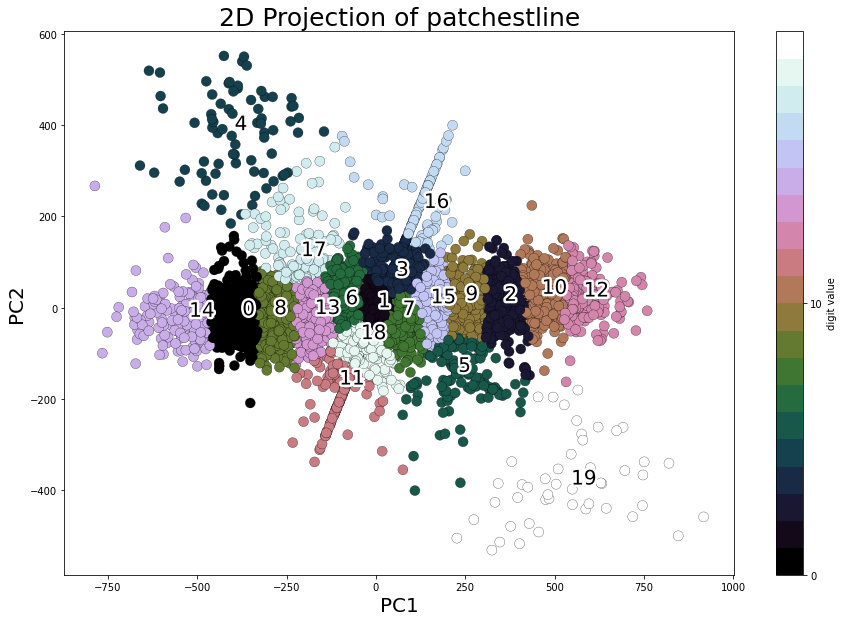

In [14]:
# perform k-means on each dir  to seperate into clusters?
from sklearn.cluster import KMeans

def perform_kmean(data,n_clusters):
    k_means = KMeans(n_clusters, random_state=0)
    k_means.fit(data)
    values = k_means.cluster_centers_.squeeze()
    labels_kmeans = k_means.labels_
    return k_means, values, labels_kmeans
n_clusters = 20

k_means= {}

for dir in directions:
    print("pca[dir]", pca[dir].shape)
    k_means[dir], values, labels_kmeans= perform_kmean(pca[dir],n_clusters)

    # plot 
    scatter(pca[dir], labels_kmeans, n_clusters, dir, output=output_folder +"/pca_kmeans_"+dir+"_"+str(n_clusters)+".png", show_labels=True)

(10000, 2) (10000,) (10000,)
REF [[134.9990414217372, 12.166858155070125, 13.0, 0.0]]
direction xline
treshold 500



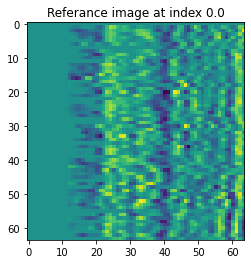

[3817.0]

number left  9999
most similar img [-109.93689613771176, 640.9985152980356, 19.0, 3817.0]


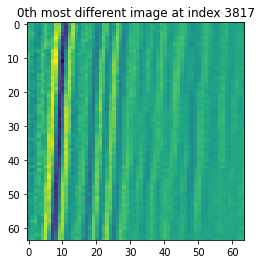

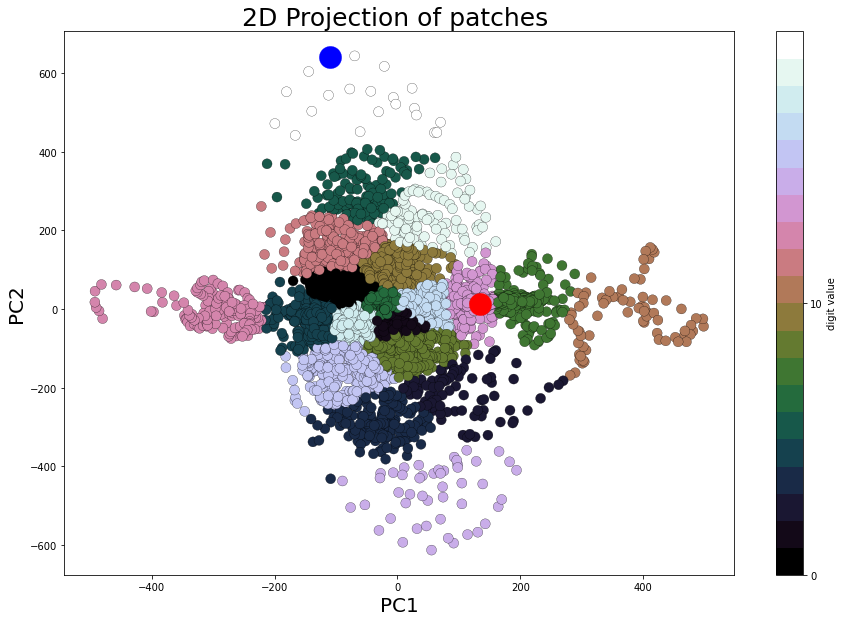

[386.0, 3431.0]

number left  9995
most similar img [82.75712453708381, -583.359478601424, 14.0, 5137.0]


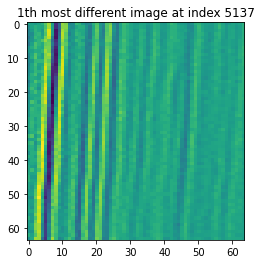

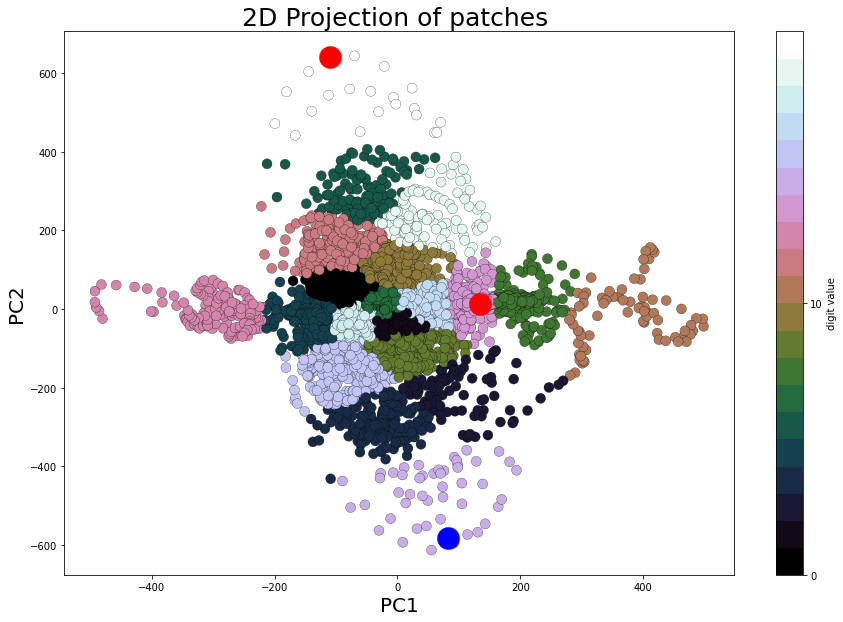

[332.0, 3485.0, 4805.0]

number left  9989
most similar img [-481.9511947742132, 62.390627637836154, 12.0, 508.0]


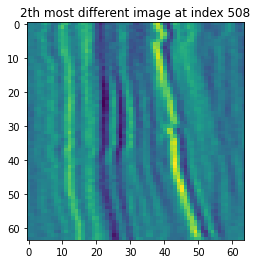

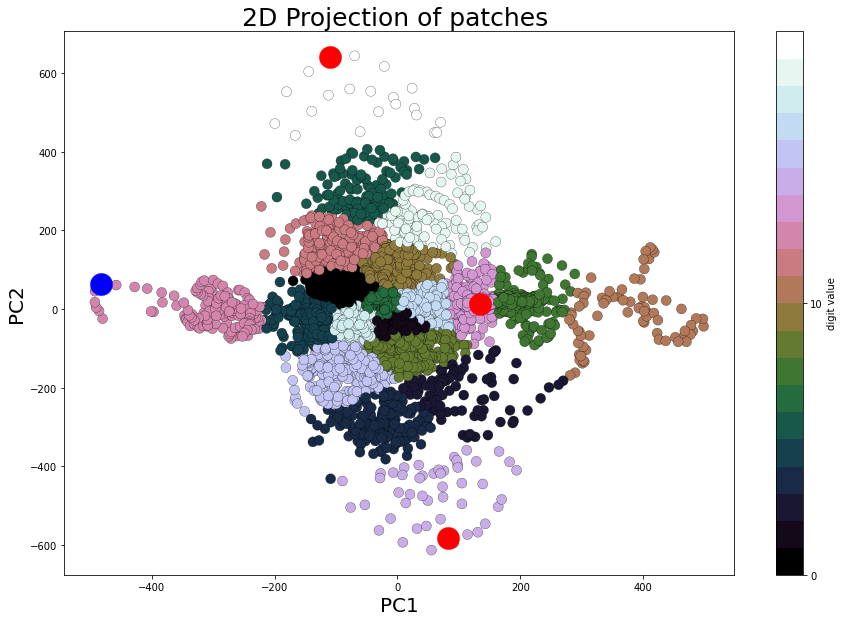

[3411.0, 406.0, 1726.0, 2903.0]

number left  9981
most similar img [468.03129237219974, -64.79424484355837, 10.0, 3235.0]


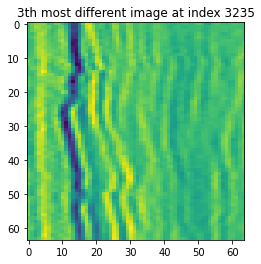

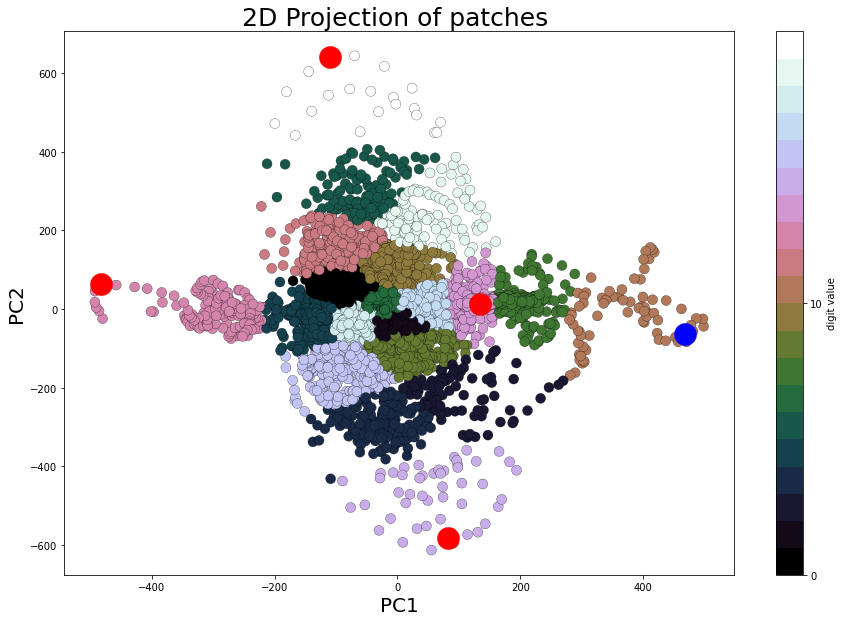

[3905.0, 88.0, 1232.0, 3397.0, 670.0]

number left  9972
most similar img [31.95985510340767, -559.104446984001, 14.0, 2585.0]


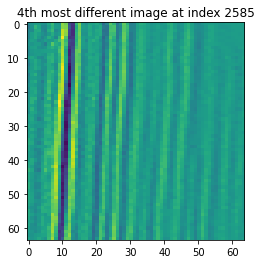

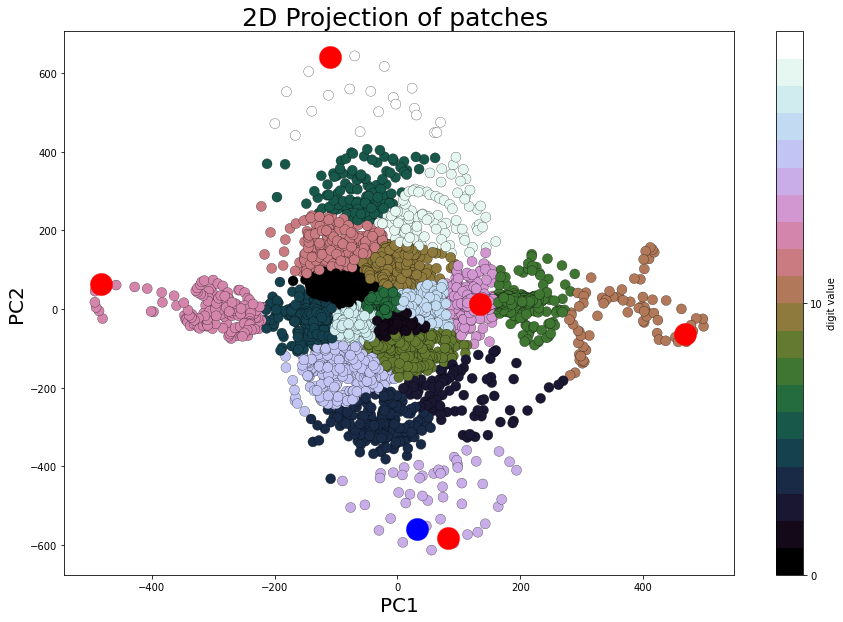

[1794.0, 2023.0, 3343.0, 1286.0, 1441.0, 791.0]

number left  9971
most similar img [-77.56387821474696, 560.0070484296734, 19.0, 1794.0]


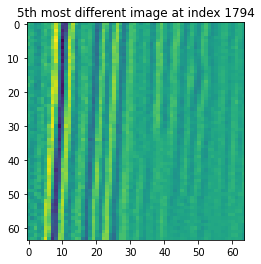

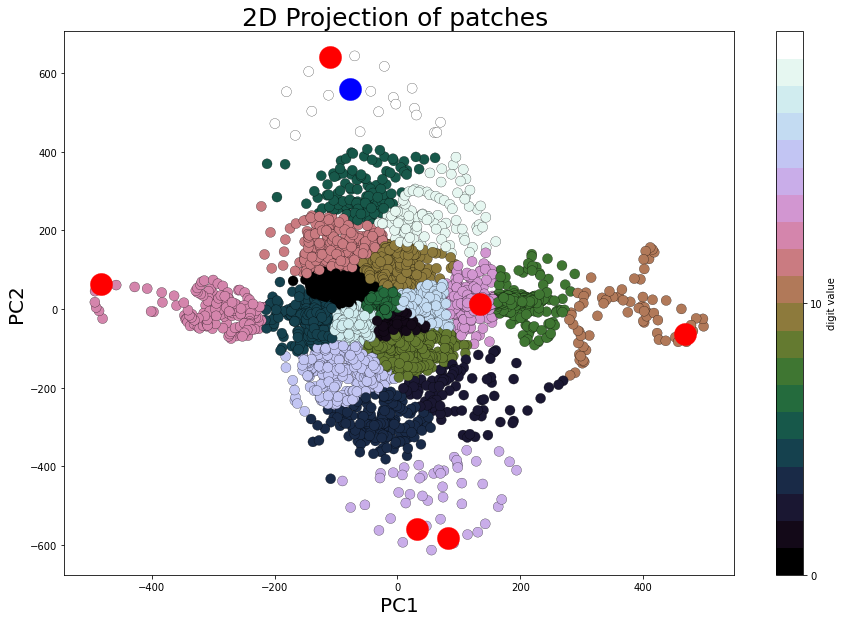

[4961.0, 1144.0, 176.0, 4453.0, 1726.0, 2376.0, 3167.0]

number left  9960
most similar img [415.4409077575539, 151.62171136312082, 10.0, 1210.0]


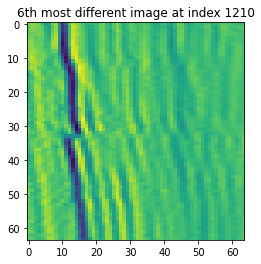

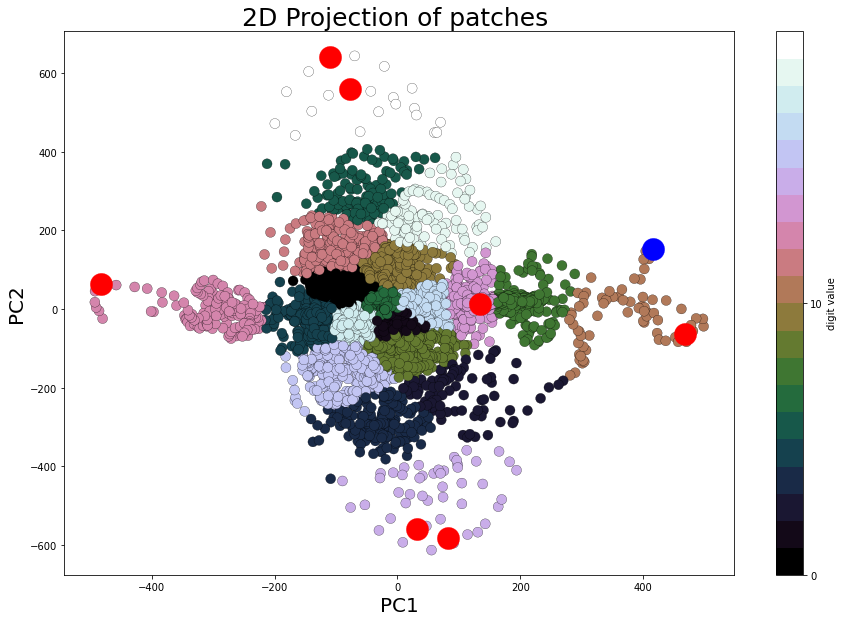

[684.0, 3133.0, 4453.0, 176.0, 2551.0, 1901.0, 1110.0, 526.0]

number left  9957
most similar img [-401.1061449343145, -6.223259211211987, 12.0, 9927.0]


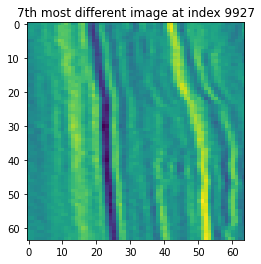

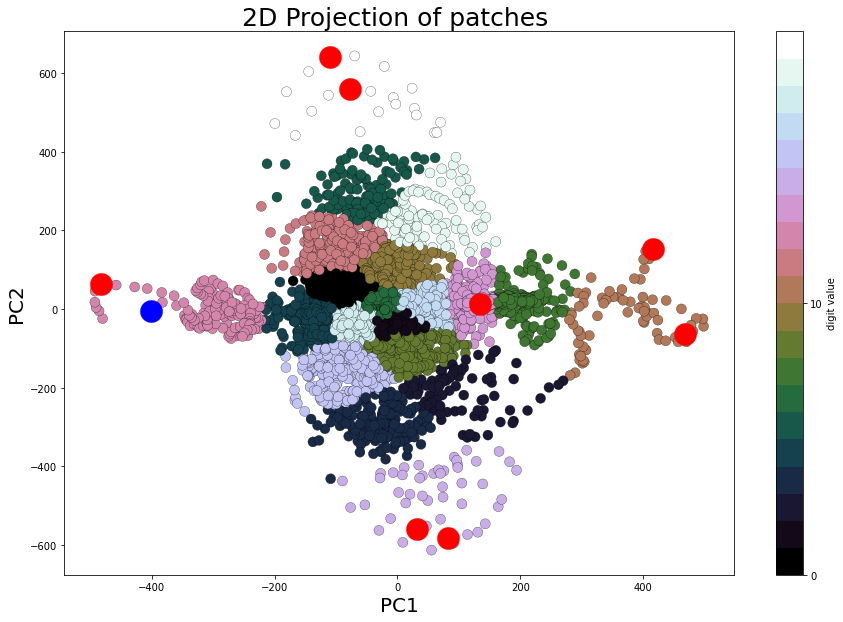

[2497.0, 1320.0, 2640.0, 1989.0, 738.0, 88.0, 703.0, 1287.0, 7430.0]

number left  9949
most similar img [-2.620288760801577, 521.5807154484079, 19.0, 6281.0]


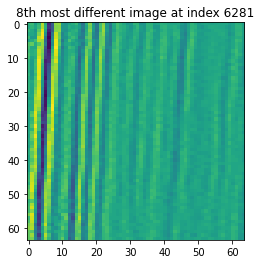

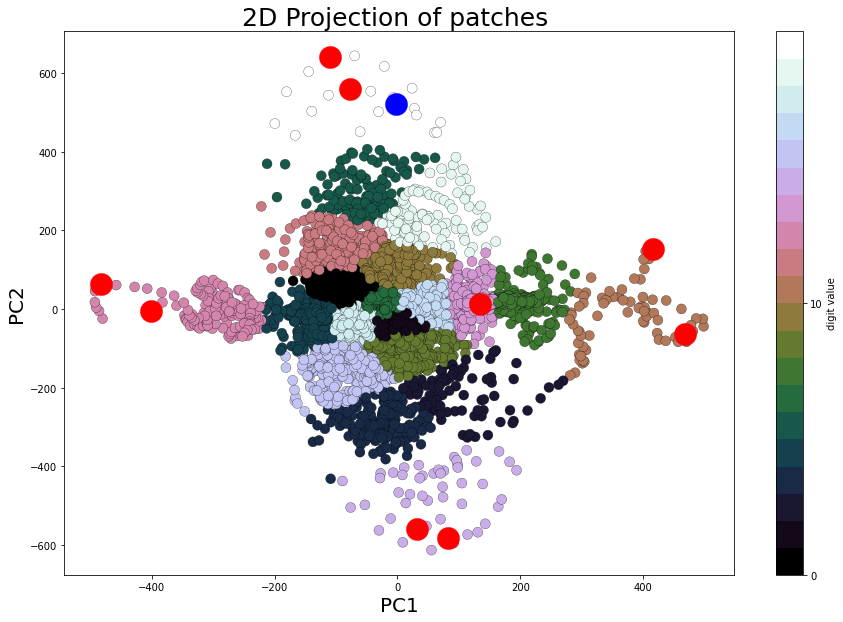

[7425.0, 3608.0, 2288.0, 6917.0, 4190.0, 4840.0, 5631.0, 6215.0, 2502.0, 1144.0]

number left  9948
most similar img [40.82786593312794, -475.80924210680047, 14.0, 7425.0]


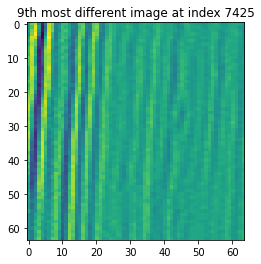

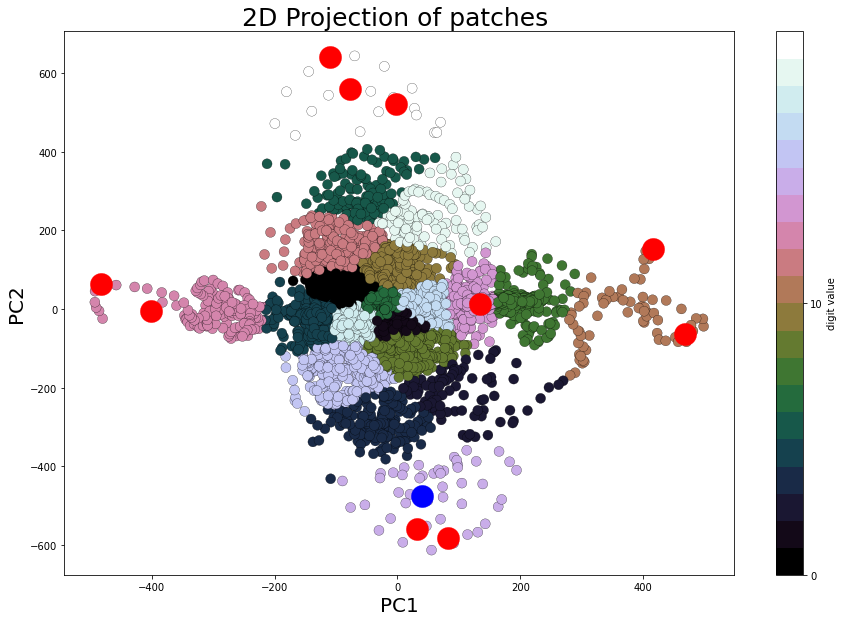

[4027.0, 210.0, 1110.0, 3519.0, 792.0, 1442.0, 2233.0, 2817.0, 5900.0, 2254.0, 3398.0]

number left  9910
most similar img [8.249006975408316, -422.45062385968197, 14.0, 5666.0]


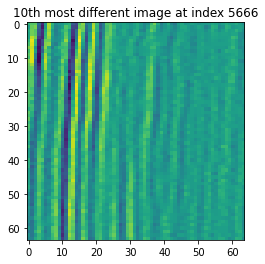

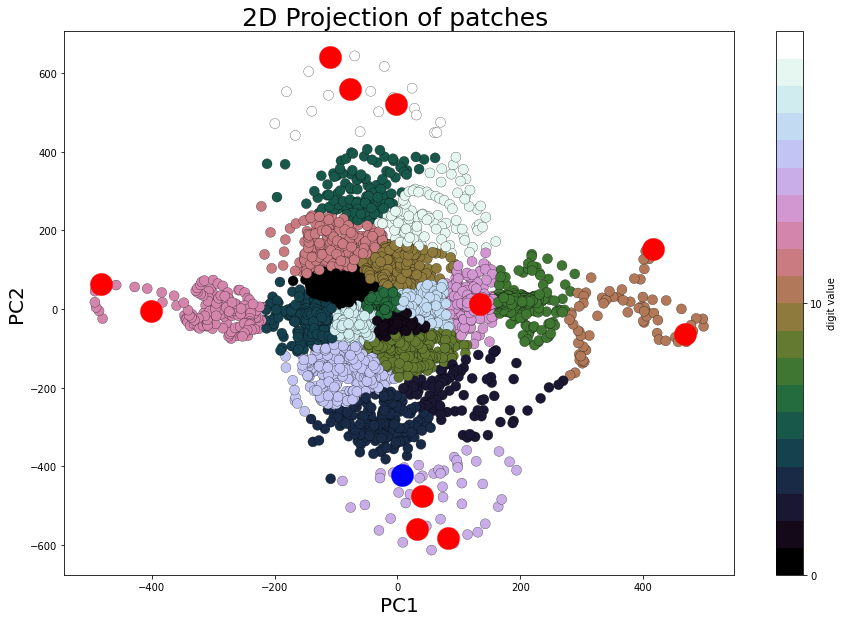

In [27]:
# now we see the indexes of the slices can still be prett close and there is nothing preventing the 10 next slices to be 10* apart.
# Ideally we would find the closest one, remove it from the leist and use it toghet with the previous ref to compute a joint distance
# distance to infer the next slice that is closes to these new points again. 

     
direction = "xline"
treshold = 500
# first we group togheter the pca and the slice index labels
print(pca[direction].shape, pca_cluster_labels.shape, patched_labels[direction].shape)

pca_cluster_labels = k_means[direction].labels_
pca_index_labels =  np.column_stack((pca[direction], pca_cluster_labels))
pca_index_labels =  np.column_stack((pca_index_labels, patched_labels[direction])) 

ref = [pca_index_labels[0].tolist()]
print("REF", ref)
print("direction", direction)
print("treshold", treshold)

#print(pca[dir][k_means[dir].labels_ == 0, :])
ag = SimilarityImageGenerator(ref, direction, treshold, pca_index_labels)
# plot the original ref
plt.imshow(patched_data[direction][int(ref[0][-1])].reshape(patch_size, patch_size).T)
plt.title(f'Referance image at index {ref[0][-1]}')
plt.show()

i = 0 
for img in ag:
    
    # for each iteration, we plot the reference and where on the cluster the next image is taken from 
    print("most similar img", img)
    # plot the next image in the sequence
    next_img = patched_data[direction][int(img[-1])].reshape(patch_size, patch_size).T
    ref_data = np.asarray(ref)
    ref_imgs = 0
    proj= pca[direction]
    proj_labels = k_means[direction].labels_ 
    proj_num_samples = n_clusters
    plot_similar_image(i, int(img[-1]), next_img, ref_imgs, ref_data, proj, proj_labels, proj_num_samples)
    
    i= i+1
    if i > 10:
        break
